An easy and secure way to share data with colleagues is using Azure Data Storage containers.

This is how I mount such container using `bibfuse` (developped by my friend Sylvain) and `systemctl --user`

# About Azure containers

From [Azure Portal](https://portal.azure.com/), you can filter for "Storage Account"

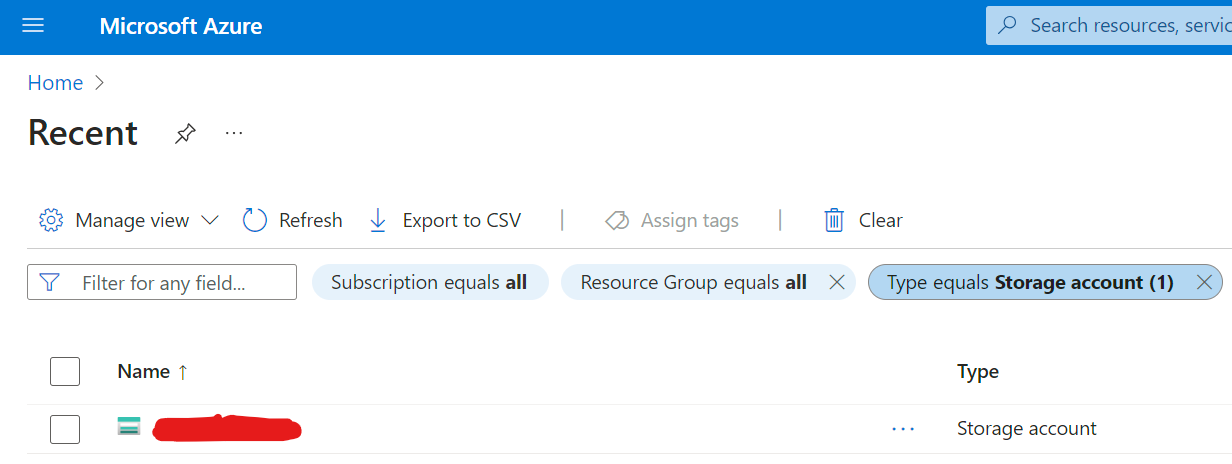

In the following page, I will use "my_storage_account"

And from "my_storage_account", I can get my storage key from "Access keys"

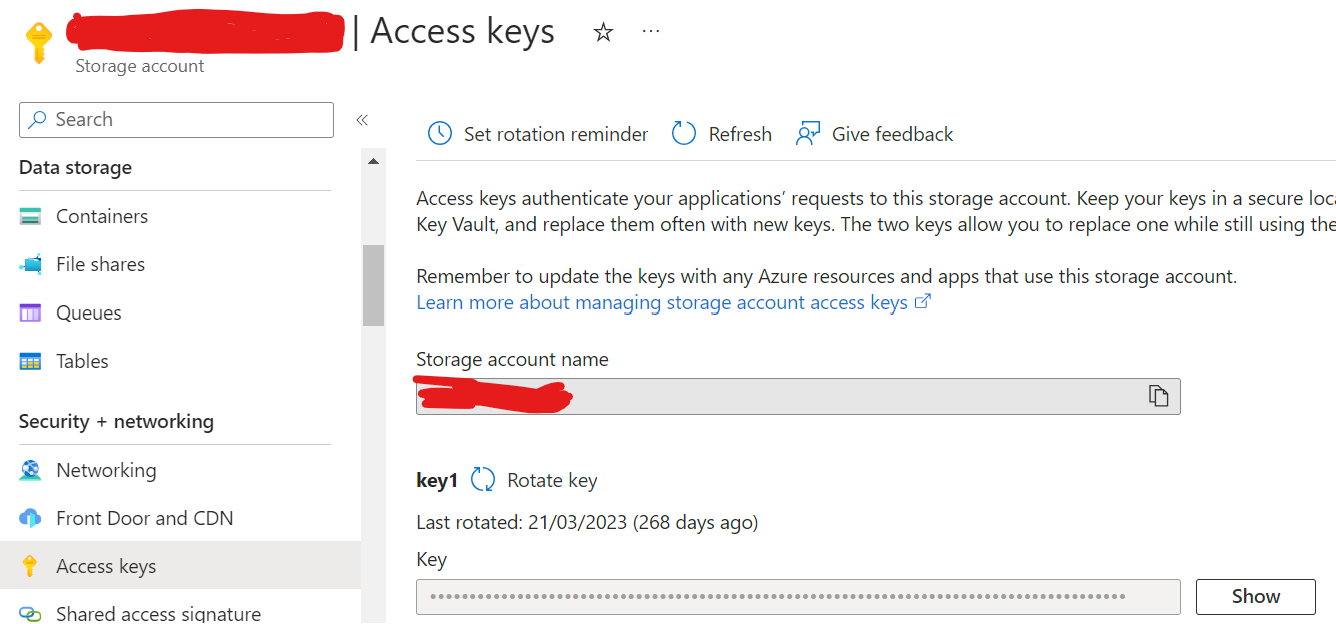

In the following page, I will use “my_storage_key”

# Installation - Set-up

## install dependancies

## configure bibfuse

Config will be in `~/.config/bibfuse`, we store that in env variable `BIBFUSE_SECURE_PATH`

And a passphrase of exactly 16-chars is expected, we store that in env variable `BLOBFUSE2_SECURE_CONFIG_PASSPHRASE`

And call `bibfuse encrypt` to create the config 

```bash
mkdir -p ~/.config/bibfuse
export BIBFUSE_SECURE_PATH=~/.config/bibfuse
export BLOBFUSE2_SECURE_CONFIG_PASSPHRASE=anypassphrase<16

bibfuse encrypt --account my_storage_account --key my_storage_key

```


This creates a `my_storage_account.yaml` config file under `~/.config/bibfuse`

And modify startup script (`.bashrc`, `.zshrc`) to export `BIBFUSE_SECURE_PATH`, `BLOBFUSE2_SECURE_CONFIG_PASSPHRASE`

Will be used by bibfuse commands

# Usage

## list all storage accounts

```bash
bibfuse list --accounts
> my_storage_account
```

## mount all containers from a storage account

in `~/AZURE`

```bash
bibfuse mount ~/AZURE --account my_storage_account --all  
```

## unmount all containers

should be called from `~/AZURE`

```bash
cd ~/AZURE
bibfuse unmount –-all
cd - 
```

## mount a given container `container_1`

```bash
bibfuse mount ~/AZURE/container_1 --account my_storage_account --container container_1
```

# Start this with `systemd --user`

I will use 4 files for that:

- `mount_azure.sh` in `~/bin` to mount all containers
- `unmount_azure.sh` in `~/bin` to unmount all containers
- `mount_azure.conf` in `~/bin` to store BIBFUSE_SECURE_PATH, BLOBFUSE2_SECURE_CONFIG_PASSPHRASE

- `bibfuse.service` in `~/.config/systemd/user` with the service logic

In [7]:
#changed filename for confidentiality reason
!cat ~/bin/mount_azure\ \(copy\).sh

#!/bin/bash
source ~/miniconda/etc/profile.d/conda.sh
source ~/bin/mount_azure.conf
export BLOBFUSE2_SECURE_CONFIG_PASSPHRASE
export BIBFUSE_SECURE_PATH
conda activate base
bibfuse mount ~/AZURE/zyoung --account my_storage_account --container container_1


In [8]:
!cat ~/bin/unmount_azure.sh

#!/bin/bash
cd ~/AZURE
source ~/miniconda/etc/profile.d/conda.sh
source ~/bin/mount_azure.conf
export BLOBFUSE2_SECURE_CONFIG_PASSPHRASE
export BIBFUSE_SECURE_PATH
conda activate base
bibfuse unmount --all
cd -


In [9]:
#changed filename for confidentiality reason
!cat ~/bin/mount_azure\ \(copy\).conf

BIBFUSE_SECURE_PATH=/home/guillaume/.config/bibfuse
BLOBFUSE2_SECURE_CONFIG_PASSPHRASE=anypassphrase<16


In [3]:
!cat ~/.config/systemd/user/bibfuse.service

[Unit]
Description=Mount azure storage account with bibfuse
DefaultDependencies=no
After=network.target

[Service]
Type=simple
#User=guillaume
#Group=guillaume
EnvironmentFile=/home/guillaume/bin/mount_azure.conf
ExecStart=/home/guillaume/bin/mount_azure.sh
ExecStop=/home/guillaume/bin/unmount_azure.sh
TimeoutStartSec=5
RemainAfterExit=yes

[Install]
WantedBy=default.target


## setup systemd --user bibfuse.service

Activate systemd for users

```bash
loginctl enable-linger guillaume
```

Load `bibfuse` service

```bash
systemctl --user daemon-reload
```

Start / Stop / Status
```bash
systemctl --user start bibfuse
systemctl --user stop bibfuse
systemctl --user status bibfuse
```

and everything looks great, activate to start at boot time
```bash
systemctl --user enable bibfuse
```

## monitor logs for bibfuse

Just the standard way, but using `--user`

```bash
journalctl –-user -f -u bibfuse

# or without -f (output appended data)
journalctl –-user -u bibfuse
```